In [188]:
import pandas as pd
import numpy as np
import folium
import json
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import sklearn
from sklearn import linear_model
import re
import gc
from babel.numbers import format_currency
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
plt.style.use('seaborn') #plt.style.availableplt.style.use('seaborn') #plt.style.available

# IPTU Joinville

Alguns dados tirados dessa fonte de arrecadação tão importante para o município

### Breve histórico ao longo dos anos

Listagem do total calculado e pago do imposto. A série histórica considera 2012 em diante.

In [2]:
dfcalc = pd.read_csv('iptu_calculado.csv')
dfpago = pd.read_csv('iptu_pago.csv')

In [3]:
calc = dfcalc.groupby('lpu_anoexercicio').sum().reset_index().rename(columns={'lpu_anoexercicio':'ano','sum':'calculado'})
pago = dfpago.groupby('lct_anodebito').sum().reset_index().rename(columns={'lct_anodebito':'ano','sum':'pago'})

**Quanto o município deverá recolher ao final de 2018?**

Regressão simples levando em conta apenas o total anual anterior. Alguns pontos a se observar:
- Além desses totais calculados e pagos, existem processos de revisão e re-cálculo durante todo o ano.
- Modelo simples apenas para ilustrar o crescimento dos valores com os anos.
- O valor pago de 2018 considera até o mês de Julho.
- Inflação está sendo levada em conta.

In [79]:
agg = calc.merge(pago, how='left', on='ano')
agg

,ano,calculado,pago
0,2012,1.106496e+08,9.066582e+07
1,2013,1.230301e+08,1.008057e+08
2,2014,1.302072e+08,1.132422e+08
3,2015,1.445469e+08,1.263882e+08
4,2016,1.606856e+08,1.353586e+08
5,2017,1.820216e+08,1.491904e+08
6,2018,1.972251e+08,1.182042e+08


Essa tabela mostra quanto foi calculado/arrecadado até julho/2018. Podemos prever quanto será recohlido até o final do ano:

In [80]:
X = agg.iloc[0:6].drop('calculado', axis=1)[['ano']]
y = agg.iloc[0:6].drop('calculado', axis=1)[['pago']]

vp = agg.iloc[6:7].drop('calculado', axis=1)[['ano']]

reg = linear_model.LinearRegression()
reg.fit(X,y)
pred = reg.predict(vp)

fmt = format_currency(pred.ravel()[0], 'R$', locale='pt_BR')
print('Total previsto para 2018: {0}'.format(fmt))


Total previsto para 2018: R$160.217.937,47


In [97]:
# Agregando a previsão à tabela

agg['pred'] = agg['pago']
agg.at[6, 'pred'] = pred.ravel()[0] # mudando apenas o valor para 2018
agg

,ano,calculado,pago,pred
0,2012,1.106496e+08,9.066582e+07,9.066582e+07
1,2013,1.230301e+08,1.008057e+08,1.008057e+08
2,2014,1.302072e+08,1.132422e+08,1.132422e+08
3,2015,1.445469e+08,1.263882e+08,1.263882e+08
4,2016,1.606856e+08,1.353586e+08,1.353586e+08
5,2017,1.820216e+08,1.491904e+08,1.491904e+08
6,2018,1.972251e+08,1.182042e+08,1.602179e+08


**Efeito da inflação**

O cálculo de um ano leva em consideração a inflação do ano anterior. Em 2015 a inflação foi de mais de 10%, [a maior desde 2002](http://g1.globo.com/economia/noticia/2016/01/inflacao-oficial-fica-em-1067-em-2015.html), fato que fica evidente no gráfico com a baixa no cálculo de 2016.

Inflação no período: 

- 2017 -> 2,21% 
- 2016 -> 6,29% 
- 2015 -> 10,67%
- 2014 -> 6,41% 
- 2013 -> 5,91% 
- 2012 -> 5,83% 
- 2011 -> 6,50%

In [94]:
inf = pd.read_csv('sem_inflacao.csv')

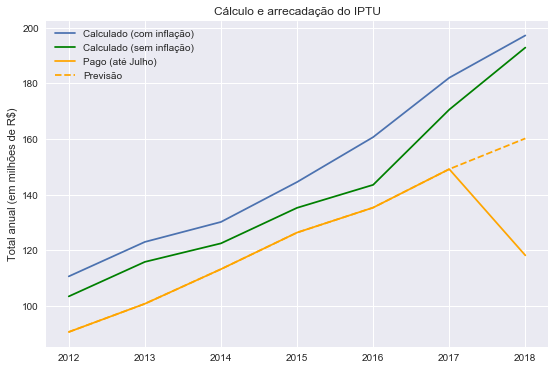

In [98]:
plt.figure(figsize=(9,6))
plt.plot(agg.ano.astype(str), agg.calculado/1000000)
plt.plot(inf.ano.astype(str), inf.valor/1000000, color='green')
plt.plot(agg.ano.astype(str), agg.pago/1000000, color='orange')
plt.plot(agg.ano.astype(str), agg.pred/1000000, color='orange', linestyle='--')
plt.title('Cálculo e arrecadação do IPTU')
plt.ylabel('Total anual (em milhões de R$)')
plt.xlabel('')
plt.legend(('Calculado (com inflação)', 'Calculado (sem inflação)', 'Pago (até Julho)', 'Previsão'), loc=2)


## 2018



### Valor calculado do IPTU por bairro

In [99]:
df = pd.read_csv('iptu_calculado18.csv')
df.head()

,lpu_anoexercicio,lpu_totalcarne,bai_descricao
0,2018,282.95,Aventureiro
1,2018,396.33,Comasa
2,2018,484.11,Boa Vista
3,2018,275.52,Bom Retiro
4,2018,134.47,Comasa


In [100]:
df_sum = df.groupby('bai_descricao').sum().drop('lpu_anoexercicio', axis=1).sort_values(by='lpu_totalcarne', ascending=False).reset_index()

In [101]:
# Arredondando os valores (dividindo por 1 milhão) e adicionando em coluna separada
df_sum['total_convert'] = round(df_sum['lpu_totalcarne']/1000000, 3)

In [102]:
df_sum.head(3)

,bai_descricao,lpu_totalcarne,total_convert
0,Zona Industrial Norte,26441670.49,26.442
1,America,18037593.58,18.038
2,Centro,15759201.12,15.759


Text(0.5,0,'Bairros')

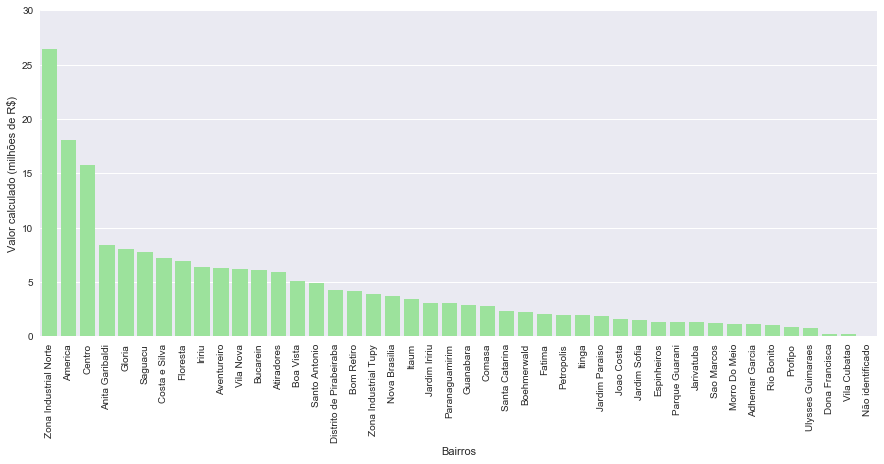

In [107]:
fig, ax = plt.subplots(figsize=(15,6))
p = sns.barplot(data=df_sum, x='bai_descricao', y='lpu_totalcarne', color='lightgreen', ax=ax)
plt.xticks(rotation=90)

# get_yticks retorna um nparray. Convertendo para inteiro para mostrar sem casas decimais
plt.yticks(p.get_yticks(), (p.get_yticks()/1000000).astype(int)) 
plt.ylabel('Valor calculado (milhões de R$)')
plt.xlabel('Bairros')

**Como fica essa divisão no mapa?**

> *Shape dos bairros baixado do [site da prefeitura](https://www.joinville.sc.gov.br/servicos/sistema-de-informacoes-municipais-georreferenciadas-simgeo/) (SIRGAS 2000 / UTM zone 22S) e convertido para o formato WGS84.*

Região sul da cidade concentra os menores valores de IPTU, enquanto a parte norte possui bairros, em sua maioria, com médias maiores. A Zona industrial Norte é o destaque do mapa como o bairro que mais arrecada. Os bairros América e Centro vem logo em seguida.

In [108]:
geo_json_data = json.load(open('bairros_jvle.geojson'))
m = folium.Map([-26.2860121,-48.8618487], zoom_start=12)

m.choropleth(
    geo_data=geo_json_data,
    data=df_sum,
    columns=['bai_descricao', 'total_convert'],
    key_on='feature.properties.nome_bairr',
    threshold_scale=[1, 5, 10, 16, 19, 27],
    legend_name='Valor calculado (milhões de R$)',
    fill_opacity=0.7,
    line_opacity=0.2,
    fill_color='BuPu',
    highlight=False
)
#m.save('jvle_iptu_valores.html')

m


## Análise exploratória da cota única 10%

Cota única 10% é uma opção para que o cidadão pague todo o carnê de uma vez até os primeiros dias do ano. Caso opte por esse pagamento, um desconto de 10% será dado ao valor final.

In [110]:
df10 = pd.read_csv('iptu_parc10.csv', encoding='ISO-8859-1')
df10.head()
df10.mvb_dtpagamento = pd.to_datetime(df10.mvb_dtpagamento)

In [111]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238754 entries, 0 to 238753
Data columns (total 7 columns):
dvd_codigo         238754 non-null int64
lct_anodebito      238754 non-null int64
lct_nrparcela      238754 non-null int64
lct_descricao      238754 non-null object
lct_situacao       238754 non-null int64
mvb_dtpagamento    87437 non-null datetime64[ns]
mvb_vlrbaixa       87437 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 12.8+ MB


Status dos carnês conforme o pagamento. 36% já foi pago:

In [112]:
df10.lct_situacao.value_counts(normalize=True)

3    0.635160
1    0.363449
5    0.001001
0    0.000331
6    0.000059
Name: lct_situacao, dtype: float64

Filtrando apenas os pagos:

In [126]:
pagos = df10[df10.lct_situacao==1].iloc[:,-2:]

### Pagos em Dezembro/17 e Janeiro/18 

**Dezembro/17**

In [114]:
pagos17 = pagos[(pagos.mvb_dtpagamento.dt.year == 2017) & (pagos.mvb_dtpagamento.dt.month == 12)]
pagos17 = pagos17.groupby(pagos17.mvb_dtpagamento.dt.day).agg(['size', 'sum']).reset_index()
pagos17

mvb_dtpagamento mvb_vlrbaixa            
                           size         sum
0                5            2      925.36
1                6           31    17099.41
2                7           75    42558.68
3                8          124    88393.41
4               11          455   285704.74
5               12          518   334836.09
6               13          746   329286.79
7               14         1001   482587.81
8               15         1302   644951.12
9               18         3135  1299076.11
10              19         2371  1117734.42
11              20         2716  1153513.50
12              21         2706  1253577.73
13              22         2914  1541381.81
14              26         3400  1541449.82
15              27         3251  1725878.39
16              28         2919  1447444.20

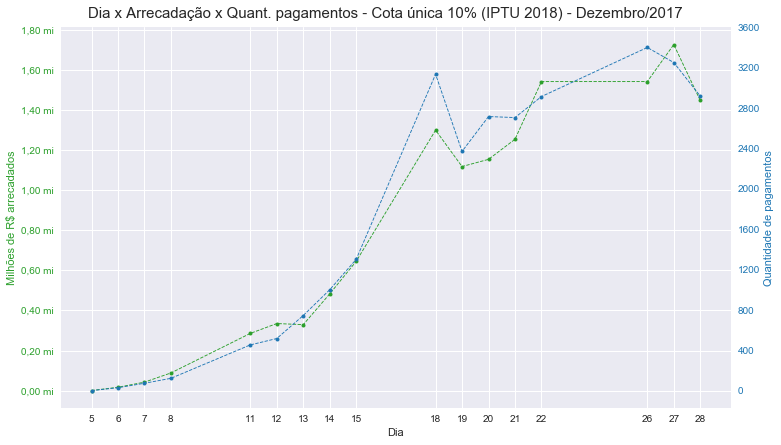

In [115]:
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.suptitle('Dia x Arrecadação x Quant. pagamentos - Cota única 10% (IPTU 2018) - Dezembro/2017' , fontsize=15, y=0.92)

linewidth = 0.9
markersize = 4

color1 = 'tab:green'
#labels
ax1.set_xlabel('Dia')
ax1.set_ylabel('Milhões de R$ arrecadados', color=color1)
#plot
ax1.plot(pagos17.mvb_dtpagamento, pagos17.mvb_vlrbaixa['sum'], linestyle='--', linewidth=linewidth, markersize = markersize, marker='o', color=color1)
# ticks
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(pagos17.mvb_dtpagamento)
# y axis
ax1.yaxis.set_major_locator(ticker.MultipleLocator(200000))
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: str('%1.2f mi' % (x*1e-6)).replace('.', ',')))

color2 = 'tab:blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(pagos17.mvb_dtpagamento, pagos17.mvb_vlrbaixa['size'], linestyle='--', linewidth=linewidth, markersize = markersize, marker='o', color=color2)
ax2.set_ylabel('Quantidade de pagamentos', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_ticks(range(0, 4000, 400))
ax2.grid(False)

plt.savefig('Arrecadacao dezembro cota unica.png')


In [128]:
print('Totais de cota única 10% em Dezembro (IPTU 2018):\n')
print('Total arrecadado: {0}'.format(pagos17.mvb_vlrbaixa['sum'].sum()))
print('Quantidade paga: {0}'.format(pagos17.mvb_vlrbaixa['size'].sum()))

Totais de cota única 10% em Dezembro (IPTU 2018):

Total arrecadado: 13306399.390000012
Quantidade paga: 27666


In [138]:
dez = df10[(df10.lct_situacao == 1) & (df10.mvb_dtpagamento.dt.month == 12) & (df10.mvb_dtpagamento.dt.year == 2017)].index.size
tudo = df10.index.size
print('Porcentagem de dez/total: {0}'.format(dez/tudo * 100))


Porcentagem de dez/total: 11.587659264347403


Pode parecer que o gráfico é cumulativo, mas não é. O pagamento aumenta conforme o mês passa.

Em dezembro, ao todo, foram **baixados R\$13.306.399,39** provenientes de  **27666 em carnês**. Isso corresponde a **11,58% de todos os carnês lançados**.

___

**Janeiro/18**

In [121]:
pagos18 = pagos[(pagos.mvb_dtpagamento.dt.year == 2018) & (pagos.mvb_dtpagamento.dt.month == 1)]
pagos18 = pagos18.groupby(pagos18.mvb_dtpagamento.dt.day).agg(['size', 'sum']).reset_index()
pagos18

mvb_dtpagamento mvb_vlrbaixa             
                          size          sum
0               2         8460   3724437.28
1               3         9956   6040367.44
2               4        12746  11563176.42
3               5        27295  40691056.22
4              15            1       527.23
5              25            2       425.90

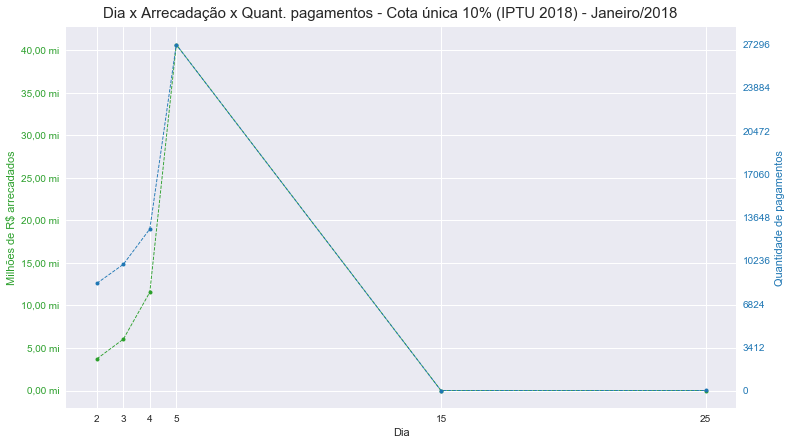

In [122]:
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.suptitle('Dia x Arrecadação x Quant. pagamentos - Cota única 10% (IPTU 2018) - Janeiro/2018', fontsize=15, y=0.92)


linewidth = 0.9
markersize = 4

color1 = 'tab:green'
#labels
ax1.set_xlabel('Dia')
ax1.set_ylabel('Milhões de R$ arrecadados', color=color1)
#plot
ax1.plot(pagos18.mvb_dtpagamento, pagos18.mvb_vlrbaixa['sum'], linestyle='--', linewidth=linewidth, markersize = markersize, marker='o', color=color1)
# ticks
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(pagos18.mvb_dtpagamento)
# y axis
ax1.yaxis.set_major_locator(ticker.MultipleLocator(5000000))
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: str('%1.2f mi' % (x*1e-6)).replace('.', ',')))

color2 = 'tab:blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(pagos18.mvb_dtpagamento, pagos18.mvb_vlrbaixa['size'], linestyle='--', linewidth=linewidth, markersize = markersize, marker='o', color=color2)
ax2.set_ylabel('Quantidade de pagamentos', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_ticks(range(0, 27300, 3412))
ax2.grid(False)

plt.savefig('Arrecadacao janeiro cota unica.png')


In [123]:
print('Totais de cota única 10% em Janeiro/18 (IPTU 2018):\n')
print('Total arrecadado: {0}'.format(pagos18.mvb_vlrbaixa['sum'].sum()))
print('Quantidade paga: {0}'.format(pagos18.mvb_vlrbaixa['size'].sum()))

Totais de cota única 10% em Janeiro/18 (IPTU 2018):

Total arrecadado: 62019990.49000017
Quantidade paga: 58460


In [140]:
jan = df10[(df10.lct_situacao == 1) & (df10.mvb_dtpagamento.dt.month == 1) & (df10.mvb_dtpagamento.dt.year == 2018)].index.size
print('Porcentagem de jan/total: {0}'.format(jan/tudo * 100))


Porcentagem de jan/total: 24.485453646849894


A arrecadação no dia 4 foi próximo ao valor arrecadado em dezembro. Dia 5 foi o pico, já que o vencimento era para essa data, com mais de R$40 milhões baixados.



Somente nesse mês, ao total, foram **R$62.019.990,49** com **58460 carnês** pagos. Isso corresponde a quase **1/4 de todos os carnês**.

### Dezembro e Janeiro agregados

Com a cota única de 10% e em apenas 2 meses, tivemos um total de **R$75.326.389,88** e **36,07% de todos os carnês pagos**. Os R\$75 milhões arrecadados ainda desconsideram os pagamentos normais de primeira parcela.

> R\$75 milhões correspondem à aproximadamente [7 meses de salário](https://transparencia.joinville.sc.gov.br/?p=5&inicio=01/01/2018&fim=31/01/2018&param=Rd5qBbJB3ysFNpuGRAaJrcgR7Ua4OD4piLwZDAYKi2O3IDTcvZjt9R0lU4aO%2Fo4LKnD97x6rE2pOc%2Bazc9oaA7coy%2B5c1ZmKXjDNPQv2oI6q%2Bob66%2Bq3RPWhSqMoRqT%2F) para todos servidores do Hospital Municipal São José

Levando em conta as despesas do município, a arrecadação da cota única de 10% é extremamente importante pois garante um 'caixa' no começo do ano para que a prefeitura distribua da melhor forma possível.

**Pagamentos fora da data de vencimento**

Sempre existem os pagamentos de cota única 10% que são feitos depois da data de vencimento. Em Janeiro, houve apenas 3 pagamentos fora do vencimento. Esse é um fato interessante, pois nos outros meses a quantidade é bem maior:

In [185]:
pos_venc = pagos[pagos.mvb_dtpagamento > '2018-01-05']
pos_venc = pos_venc.groupby(pos_venc.mvb_dtpagamento.dt.month).agg(['count', 'sum']).mvb_vlrbaixa.reset_index()
pos_venc.columns = ['Mes', 'Quant.', 'Total (R$)']

pos_venc

,Mes,Quant.,Total (R$)
0,1,3,953.13
1,2,34,15611.23
2,3,178,468619.31
3,4,265,436451.53
4,5,90,119972.79
5,6,46,51931.21
6,7,33,173565.98
